<a href="https://colab.research.google.com/github/waynew99/592-final-project/blob/main/Flirting_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Installations

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


# Load Dataset (from Hugging Face)

In [3]:
from datasets import load_dataset
dataset = load_dataset("ieuniversity/flirty_or_not")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1584 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/212 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/318 [00:00<?, ? examples/s]

In [4]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']
# train_dataset = train_dataset.with_format('tf')

In [5]:
TRAIN_SIZE = len(train_dataset)
VALIDATION_SIZE = len(validation_dataset)
TEST_SIZE = len(test_dataset)

# Preprocess Dataset: Converting Text Data into Vectors/Numbers
Models cannot directly process raw text, so we need to convert the text into numbers using TensorFlow's `TextVectorization` layer. Specifically, we can perform the following 3 operations all at once, by constructing this layer and feeding the data into it.

* Standardization: preprocessing the text, typically to change all text to lowercase and remove punctuation to simplify the dataset.
* Tokenization: dividing text into individual words called tokens.
* Vectorization: converting tokens into numbers so they can be fed into a neural network.

Constructing the layer is very easy (we simply call the function), but there are some hyperparameters we need to determine first.

## TextVectorization
First, *maximum vocabulary size* and *maximum sequence length* are 2 hyperparameters defined based on the nature of the dataset and the memory constraints of the machine.

### Maximum Vocabulary Size (`max_tokens`)

This parameter determines the number of unique words that are considered when vectorizing texts. To decide this:

*   Tokenize your dataset to find out the total number of unique tokens it contains.
*   Evaluate your hardware's memory constraints since a larger vocabulary will require more memory.

Typically, a number between 10,000 to 100,000 works well for many tasks, but if your dataset is very specialized, smaller might be enough. Also, it's often best to choose a number that is slightly above the number of unique tokens actually observed in your data to account for uncertainties. However, if the vocabulary size is significantly higher than the actual number of unique tokens, it can lead to increased memory overhead, slower training speed, and most importantly, possibility of overfitting.

In [6]:
# access the text and labels after the dataset is loaded successfully
texts = [row['texts'] for row in train_dataset]
labels = [row['label'] for row in train_dataset]

In [7]:
# sanity check
print(train_dataset)
print(validation_dataset)
print(len(texts))
print(len(labels))

Dataset({
    features: ['id', 'label', 'texts'],
    num_rows: 1584
})
Dataset({
    features: ['id', 'label', 'texts'],
    num_rows: 212
})
1584
1584


In [8]:
# Calculate the number of unique tokens using TensorFlow's tokenizer
from collections import Counter

# Flatten the list of sentences into a single list of words
all_words = [word for text in texts for word in text.split()]

# Count the unique words
word_count = Counter(all_words)
# ~4000 unique words/tokens in the training + validation set
print(f"Total unique tokens in the raw text: {len(word_count)}")

# Thus, probably use about 4000-5000 for token size
MAX_FEATURES = 4000  # Size of the vocabulary

Total unique tokens in the raw text: 3672


### Maxmimum Sequence Length (`output_sequence_length`)

This parameter controls the maximum number of tokens that will be considered in each example. To find a reasonable maximum sequence length:

- Calculate the length of each text example in your dataset.
- Plot a histogram of these lengths to get a sense of the distribution.
- Use this information to decide on a length that covers most of your texts without being excessively long.

The `output_sequence_length` parameter is used to pad or truncate sequences to this maximum length. If a text is shorter than this, it will be padded with zeros, and if it's longer, it will be truncated.

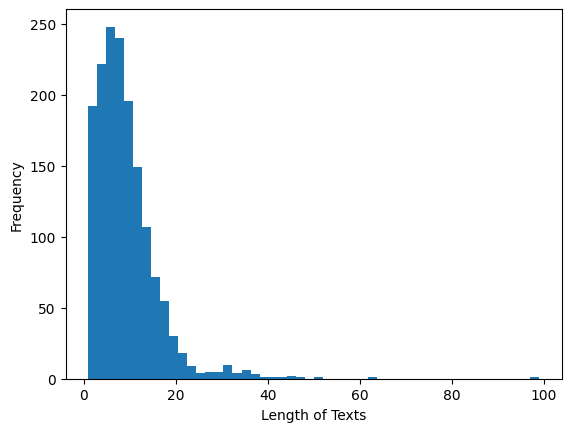

20


In [9]:
# Find a reasonable sequence length
import matplotlib.pyplot as plt

# Calculate the length for each piece of text
text_lengths = [len(text.split()) for text in texts]

# Plot a histogram
plt.hist(text_lengths, bins=50)
plt.xlabel('Length of Texts')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maximum length (e.g., the 95th percentile could be a good starting point)
SEQUENCE_LENGTH = int(np.percentile(text_lengths, 95)) # Length of the input sequences
print(SEQUENCE_LENGTH)

### Output Mode and Standardization

These are 2 more hyperparameters for the `TextVectorization` layer.

First, for output mode, we are setting it to `int`. As a result, the layer converts the tokens into integer indices. Each unique token is assigned a specific integer value, and texts are converted into sequences of these integers. In many deep learning models for text based on neural networks, `int` is the preferred option because it works very well with Embedding Layers, which are efficient and powerful mechanisms for handling sequences of tokens.

Next, for standardization, we are currently just changing each token into lowercase, a very common standardize function. We are *not* removing punctuation and special characters because there may be special characters (e.g. emojis) that actually contribute to the meaning of the text, so removing them may reduce context.

As a side note, we do not need to further define a custome split hyperparameter because splitting by whitespace (default) is sufficient for our case.

In [97]:
import re
import string

@keras.saving.register_keras_serializable()
def custom_standardization(text):
  # Make text lowercase
  text = tf.strings.lower(text)
  # # This pattern matches words followed immediately by punctuation
  # pattern = r'(\w)([' + re.escape(string.punctuation) + '])+'
  # # Replace the matched pattern with just the word character
  # text = tf.strings.regex_replace(text, pattern, r'\1')
  # Only remove common punctuation
  common_punct = r'[.,?!]'
  text = tf.strings.regex_replace(text, common_punct, '')
  return text

In [11]:
# tokenization & vectorization
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=custom_standardization, # lowercase & remove common punctuation
    output_mode='int', # int is preferred mode in modern day DL tasks
    output_sequence_length=SEQUENCE_LENGTH)

In [12]:
# adapt the TextVectorization layer to text data so that it can build the vocabulary
vectorize_layer.adapt(texts)
# test
len(vectorize_layer.get_vocabulary())

2878

In [13]:
# # Let's prepare a dataset to illustrate the functionality
# example_dataset = tf.data.Dataset.from_tensor_slices(["Hello!", "Hello !", "It's a? test 😉?", "It's a test :) :("])
# vectorize_layer.adapt(example_dataset)

# print(vectorize_layer.get_vocabulary())

# # Example of how the layer will preprocess the data
# for example in example_dataset:
#     print("Original:", example.numpy())
#     vectorized_text = vectorize_layer(example)
#     print("Vectorized:", vectorized_text.numpy())

## Convert to Tensorflow Dataset (for training)

Now, we can convert the raw text data into a form that a TensorFlow machine learning model can understand (i.e., numeric tensors) using the TextVectorization layer, preparing it in batches to be fed into the model for training or inference.

We can either (1) do the convertion as part of data preprocessing, or (2) leave it to the LSTM model itself. Option (2) generalizes better if we want to deploy and test the model since it can automatically convert text into numbers without any manual preprocessing, so we are going with this option.

In [14]:
# another hyperparameter
BATCH_SIZE = 32
# takes text data (a list of strings) and creates Dataset object
# each element of the dataset is one piece of text from your original list
text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(BATCH_SIZE)
# Turn the texts into sequences of integers [Option 1]
# text_int_sequences = text_ds.map(vectorize_layer)
# convert corresponding labels to tensorflow format
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int32)).batch(BATCH_SIZE)

In [15]:
# integer representing the number of elements to shuffle at a time
shuffle_buffer_size = TRAIN_SIZE # the number of data in the training set
# build the training dataset & optimize it for training
# train_ds = tf.data.Dataset.zip((text_int_sequences, label_ds)) \ # [Option 1]
train_ds = tf.data.Dataset.zip((text_ds, label_ds)) \
            .shuffle(buffer_size=shuffle_buffer_size) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

### Convert Validation Set and Test Set as well

In [16]:
val_texts = [row['texts'] for row in validation_dataset]
val_labels = [row['label'] for row in validation_dataset]
val_text_ds = tf.data.Dataset.from_tensor_slices(val_texts).batch(BATCH_SIZE)
val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels, tf.int32)).batch(BATCH_SIZE)
# val_text_int_sequences = val_text_ds.map(vectorize_layer) # [Option 1]
# note: no shuffling for validation and test sets
val_ds = tf.data.Dataset.zip((val_text_ds, val_label_ds)) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
test_texts = [row['texts'] for row in test_dataset]
test_labels = [row['label'] for row in test_dataset]
test_text_ds = tf.data.Dataset.from_tensor_slices(test_texts).batch(BATCH_SIZE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int32)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.zip((test_text_ds, test_label_ds)) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# sanity check
# for example, label in val_ds.take(1):
#   print('texts: ', example.numpy())
#   print()
#   print('labels: ', label.numpy())
# exact_sample_count = sum(1 for _ in train_ds.unbatch())  # This can be slow for large datasets
# print("Total number of samples in train_ds:", exact_sample_count)

# Build LSTM Model

In [26]:
from tensorflow.keras import layers

# More Hyperparameters
EMBEDDING_DIM = 64    # Dimension of the embedding vectors
LSTM_UNITS = 64       # The number of units in the LSTM layer
DROPOUT_RATE = 0.1

model = tf.keras.Sequential([
    # [Option 2] convert text to vectors
    vectorize_layer,
    # TODO: can switch the embedding to be a pre-trained model, e.g. word2vec
    layers.Embedding(
        input_dim=MAX_FEATURES + 1,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        mask_zero=True),
    # Avoid overfitting
    layers.SpatialDropout1D(DROPOUT_RATE),
    # LSTM layer
    layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE,
        recurrent_dropout=DROPOUT_RATE),
    # using sigmoid activation function for binary classification problem
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
MAX_FEATURES

4000

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 20, 64)            256064    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 64)            0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 289153 (1.10 MB)
Trainable params: 28915

# Training

In [29]:
# Even More Hyperparameters
EPOCHS = 10

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10
50/50 [==============================] - 6s 46ms/step - loss: 0.6727 - accuracy: 0.6149 - val_loss: 0.6059 - val_accuracy: 0.6981
Epoch 2/10
50/50 [==============================] - 2s 44ms/step - loss: 0.5032 - accuracy: 0.7879 - val_loss: 0.5073 - val_accuracy: 0.7358
Epoch 3/10
50/50 [==============================] - 2s 40ms/step - loss: 0.3446 - accuracy: 0.8662 - val_loss: 0.5533 - val_accuracy: 0.7217
Epoch 4/10
50/50 [==============================] - 2s 33ms/step - loss: 0.2454 - accuracy: 0.9097 - val_loss: 0.6548 - val_accuracy: 0.6934
Epoch 5/10
50/50 [==============================] - 2s 33ms/step - loss: 0.1715 - accuracy: 0.9394 - val_loss: 0.7060 - val_accuracy: 0.6792
Epoch 6/10
50/50 [==============================] - 2s 34ms/step - loss: 0.1255 - accuracy: 0.9577 - val_loss: 0.7509 - val_accuracy: 0.6934
Epoch 7/10
50/50 [==============================] - 2s 45ms/step - loss: 0.0928 - accuracy: 0.9691 - val_loss: 0.7941 - val_accuracy: 0.6840
Epoch 8/10
50

In [47]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

10/10 [==============================] - 0s 6ms/step - loss: 1.0561 - accuracy: 0.7138
Test Loss: 1.056085228919983
Test Accuracy: 0.7138364911079407


In [31]:
sample_text = ('i hate you')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 323ms/step


array([[0.13609138]], dtype=float32)

# Analysis

## Training Plots

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

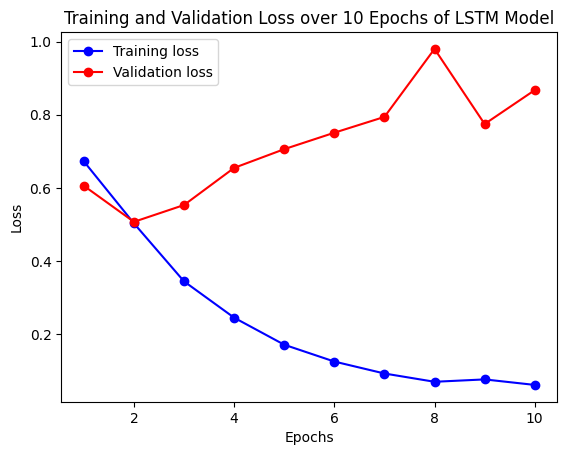

In [43]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo-', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title(f'Training and Validation Loss over {EPOCHS} Epochs of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

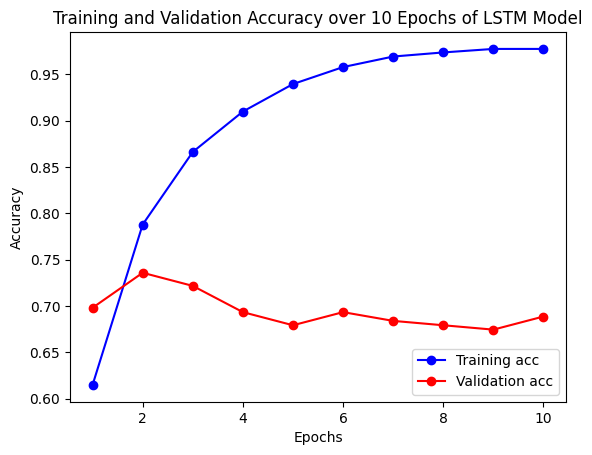

In [46]:
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title(f'Training and Validation Accuracy over {EPOCHS} Epochs of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix

# make predictions on test set
y_pred = model.predict(test_ds)
# convert these probabilities to binary predictions
# e.g., classify samples with a probability > 0.5 as positive (flirty)
y_pred_binary = (y_pred > 0.5).astype("int32")
# Prepare the true labels. You'll need to concatenate them into one array.
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

10/10 [==============================] - 0s 10ms/step


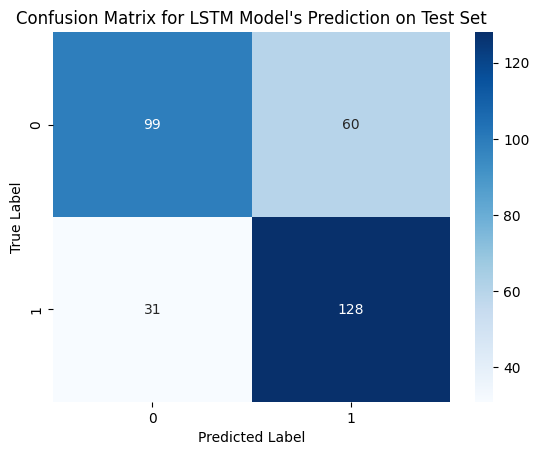

In [58]:
import seaborn as sns

# plot the confusion matrix using seaborn (for better visualization)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix for LSTM Model's Prediction on Test Set")
plt.show()

## See Wrong Predictions

In [79]:
# Get binary prediction produced by model
y_pred1 = (y_pred > 0.5).astype("int32").flatten()
# Collect true labels
y_true1 = np.concatenate([labels.numpy() for inputs, labels in test_ds]).flatten()
# Collect input data (assuming the input data is a NumPy array or a list)
x_test1 = np.concatenate([inputs.numpy() for inputs, labels in test_ds]).flatten()

In [86]:
# Identify indices of incorrect predictions
false_positives = np.where((y_pred1 == 1) & (y_true1 == 0))[0]
false_negatives = np.where((y_pred1 == 0) & (y_true1 == 1))[0]
# Retrieve the corresponding input text for false positives and false negatives
fp_texts = [x_test1[i] for i in false_positives]
fn_texts = [x_test1[i] for i in false_negatives]

In [90]:
# Now, if you want to visualize some of them:
print("False Positives:")
for i, fp_idx in enumerate(false_positives[:10]):  # Show first 10 false positives
  print(f"Text: {fp_texts[i]} - Predicted: {y_pred[fp_idx]}, Actual: {y_true[fp_idx]}")
print("\n")
print("False Negatives:")
for i, fn_idx in enumerate(false_negatives[:10]):  # Show first 10 false negatives
  print(f"Text: {fn_texts[i]} - Predicted: {y_pred[fn_idx]}, Actual: {y_true[fn_idx]}")

False Positives:
Text: b'Well we matched on Harry lol what\xe2\x80\x99s ur fav song' - Predicted: [0.94791275], Actual: 0
Text: b"i'm sticking around uni for a while \xf0\x9f\x98\xb8" - Predicted: [0.9973261], Actual: 0
Text: b'That\xe2\x80\x99s what I\xe2\x80\x99m drinking tonight' - Predicted: [0.8218022], Actual: 0
Text: b"i've played a whole heap of instruments but i completely suck at them all except the uke" - Predicted: [0.94333035], Actual: 0
Text: b'Autocorrect' - Predicted: [0.5687064], Actual: 0
Text: b"so you're from brisbane?" - Predicted: [0.9606267], Actual: 0
Text: b'i have to be really careful now because i talked about siberia and she thought that was a country' - Predicted: [0.8908131], Actual: 0
Text: b'idk' - Predicted: [0.7029357], Actual: 0
Text: b'It just gets so tiring \xf0\x9f\x98\x9e' - Predicted: [0.89287955], Actual: 0
Text: b'do you live in st kilda?' - Predicted: [0.9846808], Actual: 0


False Negatives:
Text: b'oh yeah...' - Predicted: [0.32031646], Actu

# Save the Model

In [100]:
model.save('LSTM-Flirt.keras')

In [101]:
from tensorflow import keras

new_model = keras.models.load_model('LSTM-Flirt.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 20, 64)            256064    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 64)            0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 289153 (1.10 MB)
Trainable params: 28915

In [102]:
new_model.evaluate(test_ds)

10/10 [==============================] - 1s 5ms/step - loss: 1.0561 - accuracy: 0.7138


[1.056085228919983, 0.7138364911079407]